In [1]:
#@title Imports and Initialization
# %pip install datasets
# %pip install textwrap
# %pip install openai
# %pip install scipy
# %pip install matplotlib

import collections
from abc import ABC
import datasets
import json
import openai
import numpy as np
from scipy.special import softmax
import textwrap
import matplotlib.pyplot as plt
from IPython.display import clear_output

OPENAI_SECRET_KEY = None

clear_output()

# Setup the OpenAI API

1. Go to www.openai.com and log into your account.
2. Go to https://platform.openai.com/account/api-keys and click the "Create new secret key" button. It doesn't matter what you name it.
3. Copy your API key, and then run the code block below. It will ask you to enter your secret key into a text box.

In [2]:
if OPENAI_SECRET_KEY is None:
  print("Please paste your OpenAI API key here:")
  OPENAI_SECRET_KEY = input().strip()
openai.api_key = OPENAI_SECRET_KEY
clear_output()

class OpenAIEngine():
  def __init__(self, model_name):
    self.model_name = model_name

  def score(self, text):
    """Tokenizes and scores a piece of text.

    This only works for the OpenAI models which support the legacy `Completion`
    API.

    The score is log-likelihood. A higher score means a token was more
    likely according to the model.

    Returns a list of tokens and a list of scores.
    """
    response = openai.Completion.create(
        engine=self.model_name,
        prompt=text,
        max_tokens=0,
        logprobs=1,
        echo=True)

    tokens = response["choices"][0]["logprobs"]["tokens"]
    logprobs = response["choices"][0]["logprobs"]["token_logprobs"]
    if logprobs and logprobs[0] is None:
      # GPT-3 API does not return logprob of the first token
      logprobs[0] = 0.0
    return tokens, logprobs

  def perplexity(self, text):
    """Compute the perplexity of the provided text."""
    completion = openai.Completion.create(
        model=self.model_name,
        prompt=text,
        logprobs=0,
        max_tokens=0,
        temperature=1.0,
        echo=True)
    token_logprobs = completion['choices'][0]['logprobs']['token_logprobs']
    nll = np.mean([i for i in token_logprobs if i is not None])
    ppl = np.exp(-nll)
    return ppl

  def generate(self,
               prompt,
               top_p=1.0,
               num_tokens=32,
               num_samples=1,
               frequency_penalty=0.0,
              presence_penalty=0.0):
    """Generates text given the provided prompt text.

    This only works for the OpenAI models which support the legacy `Completion`
    API.

    If num_samples is 1, a single generated string is returned.
    If num_samples > 1, a list of num_samples generated strings is returned.
    """
    response = openai.Completion.create(
      engine=self.model_name,
      prompt=prompt,
      temperature=1.0,
      max_tokens=num_tokens,
      top_p=top_p,
      n=num_samples,
      frequency_penalty=frequency_penalty,
      presence_penalty=presence_penalty,
      logprobs=1,
    )
    outputs = [r["text"] for r in response["choices"]]
    return outputs[0] if num_samples == 1 else outputs


  def chat_generate(self,
                    previous_messages,
                    top_p=1.0,
                    num_tokens=32,
                    num_samples=1,
                    frequency_penalty=0.0,
                    presence_penalty=0.0):
    response = openai.ChatCompletion.create(
      model=self.model_name,
      messages=previous_messages,
      temperature=1.0,
      max_tokens=num_tokens,
      top_p=top_p,
      frequency_penalty=frequency_penalty,
      presence_penalty=presence_penalty,
      n=num_samples,
    )
    return response

# Question 1: Observing the Impact of Decoding Strategy

## 1.1: Rolling a Twenty-Sided Die

In [87]:
MODEL_NAME = "davinci-002"
engine = OpenAIEngine(MODEL_NAME)

In [458]:
number_map = {
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
    "twelve": 12,
    "thirteen": 13,
    "fourteen": 14,
    "fifteen": 15,
    "sixteen": 16,
    "seventeen": 17,
    "eighteen": 18,
    "nineteen": 19,
    "twenty": 20
}

In [955]:
# prompt = "Let's roll a D20. The die shows the number"
# prompt = "Let's roll a D20, which randomly get a number from 1 to 20, the number is?"
# prompt = "Let's roll a D20, which number does this die show?"
prompt = "Let's roll a D20, the number is"
rolls = engine.generate(prompt, num_tokens=2, num_samples=128, top_p=0.2)
# rolls = engine.generate(prompt, num_samples=128, top_p=0.8)
expected_number_of_outcomes = 20

In [956]:
rolls_counter = collections.Counter()

for roll in rolls:
  try:
    roll_num = int(roll.strip())
    # Let's label invalid numbers as -1
    roll_num = roll_num if 1 <= roll_num <= 20 else -1
  except ValueError:
    # Let's just label invalid generation as a roll of -1.
    if (number_map.get(roll.lower().strip())):
        roll_num = number_map.get(roll.lower().strip());
    else:
        roll_num = -1
  rolls_counter[roll_num] += 1

print(rolls_counter)
print("Percentage of valid outcomes generated:",
      (len(rolls_counter)-1)/expected_number_of_outcomes)

Counter({-1: 47, 15: 32, 10: 26, 20: 23})
Percentage of valid outcomes generated: 0.15


In [957]:
set(rolls)

{' 10', ' 15', ' 20', ' the number'}

In [958]:
for roll in rolls:
    print(roll)

 the number
 15
 15
 15
 20
 the number
 10
 the number
 10
 10
 the number
 15
 20
 10
 10
 10
 15
 15
 20
 the number
 the number
 the number
 the number
 10
 15
 10
 20
 15
 the number
 the number
 15
 20
 the number
 15
 the number
 10
 the number
 15
 20
 10
 10
 the number
 the number
 20
 15
 15
 10
 the number
 the number
 10
 the number
 the number
 20
 10
 the number
 15
 10
 15
 15
 15
 20
 the number
 the number
 20
 10
 10
 the number
 15
 20
 15
 20
 10
 20
 10
 the number
 the number
 15
 10
 the number
 the number
 10
 15
 the number
 the number
 the number
 the number
 20
 the number
 the number
 the number
 the number
 20
 15
 15
 the number
 the number
 15
 20
 20
 the number
 10
 10
 15
 15
 20
 the number
 the number
 15
 the number
 15
 10
 15
 10
 the number
 15
 20
 20
 15
 20
 20
 20
 the number
 10
 15
 the number
 the number
 the number
 the number


In [959]:
def get_valid_counter(counter):
    # Define the value to remove
    value_to_remove = -1

    # Get the frequency of the value to remove
    frequency_to_remove = counter[value_to_remove]

    # Remove the value from the Counter
    counter.subtract({value_to_remove: frequency_to_remove})

    # Remove any negative counts (optional)
    for key in list(counter):
        if counter[key] <= 0:
            del counter[key]

    return(counter)

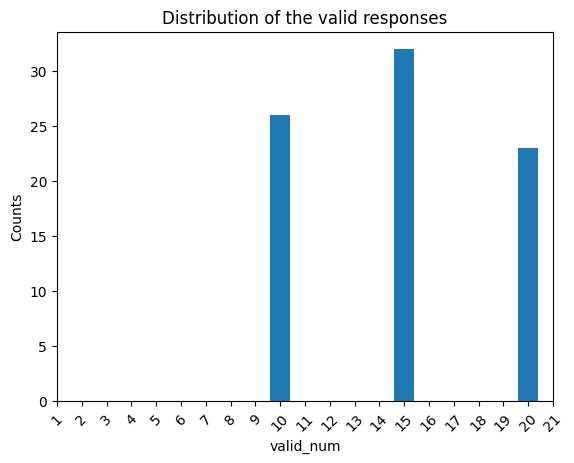

In [960]:
# unique_tokens, counts = np.unique(rolls, return_counts=True)
valid_counter = get_valid_counter(rolls_counter)
valid_num, counts = zip(*valid_counter.items())

# str_num = [str(num) for num in valid_num]

plt.bar(valid_num, counts)
plt.xlabel('valid_num')
plt.ylabel('Counts')
plt.title('Distribution of the valid responses')
plt.xticks(rotation=45)
plt.xticks(range(1, 22))
plt.show()

In [736]:
# try random generation
import random

rand_counter = collections.Counter()

for i in range(40):
    rand = random.randint(1, 20)
    rand_counter[rand] += 1
    # print(i)

print(rand_counter)
print("Percentage of valid outcomes generated:",
      (len(rand_counter)-1)/expected_number_of_outcomes)

Counter({17: 4, 19: 4, 12: 4, 6: 3, 1: 3, 11: 3, 16: 3, 13: 2, 4: 2, 9: 2, 8: 2, 14: 2, 7: 1, 20: 1, 10: 1, 3: 1, 18: 1, 2: 1})
Percentage of valid outcomes generated: 0.85


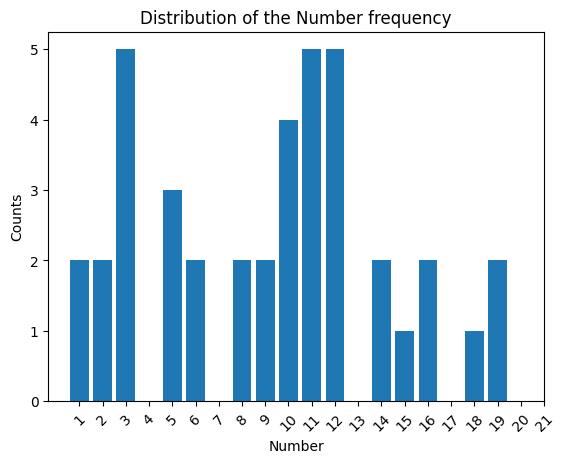

In [607]:
num, counts = zip(*rand_counter.items())

# str_num = [str(num) for num in valid_num]

plt.bar(num, counts)
plt.xlabel('Number')
plt.ylabel('Counts')
plt.title('Distribution of the Number frequency')
plt.xticks(rotation=45)
plt.xticks(range(min(valid_num), 22))
plt.show()

## 1.2: Longform Generation

In [16]:
import math

def calculate_ttr(text):
    words = text.split()
    unique_words = set(words)
    ttr = len(unique_words) / len(words)
    return ttr

def calculate_malones_measure(text):
    words = text.split()
    unique_words = set(words)
    d = 1 - (len(unique_words) / len(words))
    return d

def calculate_herdans_c(text):
    words = text.split()
    unique_words = set(words)
    vocabulary_size = len(unique_words)
    n = len(words)
    c = vocabulary_size / math.sqrt(n)
    return c

In [68]:
def output_res(res, top_p, frequency_penalty):
    print(f'Response: {res}\n')
    print(f'top_p = {top_p}')
    print(f'frequency_penalty = {frequency_penalty}')
    print(f'TTR: {calculate_ttr(res)}')
    # print(f'Malone\'s Measure: {calculate_malones_measure(res)}')
    # print(f'Herdan\'s C: {calculate_herdans_c(res)}')

### Using a prompt of your choice, instruct the language model to generate a 256-token story.

In [60]:
# Prompt with top_p = 0.0
prompt = "Once upon a time, there is a scientist wanting to create a time machine"
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=0.0)

output_res(res, 0.0)

Response: . He has a lot of money and he is very smart. He has a lot of ideas and he is very creative. He has a lot of time and he is very patient. He has a lot of people and he is very friendly. He has a lot of materials and he is very rich. He has a lot of time and he is very patient. He has a lot of money and he is very rich. He has a lot of people and he is very friendly. He has a lot of ideas and he is very creative. He has a lot of materials and he is very rich. He has a lot of time and he is very patient. He has a lot of money and he is very rich. He has a lot of people and he is very friendly. He has a lot of ideas and he is very creative. He has a lot of materials and he is very rich. He has a lot of time and he is very patient. He has a lot of money and he is very rich. He has a lot of people and he is very friendly. He has a lot of ideas and he is very creative. He has a lot of materials and he is very rich. He has a lot of time and he is very patient. He has a

top_p = 0.0


In [61]:
# Prompt with top_p = 0.5
prompt = "Once upon a time, there is a scientist wanting to create a time machine"
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.5, frequency_penalty=0.0)
output_res(res, 0.5)

Response: . He found a way to do it, but he also found out that the time machine is not able to go back in time. The scientist was so disappointed. But he found out that the time machine can go forward in time. So he started to create a new time machine that can go forward in time. The scientist created a new time machine and it was able to go forward in time. He was so happy.

But the scientist also found out that the time machine is not able to go forward in time. He was so disappointed. He thought about it and thought about it. He finally found out that the time machine can go forward in time. So he started to create a new time machine that can go forward in time. The scientist created a new time machine and it was able to go forward in time. He was so happy.

But the scientist also found out that the time machine is not able to go forward in time. He was so disappointed. He thought about it and thought about it. He finally found out that the time machine can go forward in time. So 

In [62]:
# Prompt with top_p = 1.0
prompt = "Once upon a time, there is a scientist wanting to create a time machine"
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=1.0, frequency_penalty=0.0)
output_res(res, 1.0)

Response:  to butterfly effect his time interpreting the phrase ‘I’m confident.’ followed by the sentence, “Because I’ve got a time machine.” three years ago. He built the time machine but as he figured to manipulate it accordingly, it played cat and mouse mentality with him (as if it really occurs) by jumping back a fourth year, second month, third day until chaos rules this contorted sort of timeline. It crossed with the other son of a time traveller - Kay Murphy II. Realising this is a self-consistent rotating plot paradox, everything's tidy in this timeline. However, it quizzes the scientist and the time machine. The scientist tried to breaking in and busting open the time machine right away but it didn’t help at all. Quickly he sensed the scientist’s blunder and then cut the chain. Whilst the time machine nudged away and being mashed time up, the scientist seems rather unconcerned knowing that one of his kind is here. He flipped the switch and left.. Thug leaves a letter for Kay’s

### prompt the language model with the opening sentence from a renowned book or speech

In [63]:
# prompt = "It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness,"
# Prompt with top_p = 0.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=0.0)
output_res(res, 0.0)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day even the state of Mississippi, a desert state, sweltering with the heat of injustice and oppression, will be transformed into an oasis of freedom and justice. I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character. I have a dream today. I have a dream that one day, down in Alabama, with its vicious racists, with its governor having his lips dripping with the words of interposition and nullification; one day right there in Alabama little black boys and black girls will be able to join hands with little white boys and white girls as sisters and brothers. I have a dream today. I have a dream that one day every valley shall be exalted, every hill and mountain sh

In [64]:
# Prompt with top_p = 0.5
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.5, frequency_penalty=0.0)
output_res(res, 0.5)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day even the state of Mississippi, a desert state, sweltering with the heat of injustice and oppression, will be transformed into an oasis of freedom and justice. I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character. I have a dream today.

“When we let freedom ring, when we let it ring from every village and every hamlet, from every state and every city, we will be able to speed up that day when all of God’s children, black men and white men, Jews and Gentiles, Protestants and Catholics, will be able to join hands and sing in the words of the old Negro spiritual, ‘Free at last! Free at last! Thank God Almighty, we are free at last!’”

It was the most famous sp

In [65]:
# Prompt with top_p = 1.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=1.0, frequency_penalty=0.0)
output_res(res, 1.0)

Response:  12 'We shall overcome': Read civil rights great still 'rattling in the rusted-out cans of a Jim Crow era'

Donald Trump compares his fantasy border to the wall of China

Former Trump employee's George Papadopoulos says Trump a 'skilled conservator of destructive impulses'

Trump adviser Flynn gives first interview since pleading guilty to lying to FBI

The Russians invaded the US election and succeeded. Trump started with talking and selling, and moved to blackmail, threats, and finally the actual rigging of the election, which has he benefited from enormously. Nixon warned not to start the process of demanding something you can’t get; then step by step he is radicalsized into doing things that lead to Watergate. Grossmann — Russia 2018 – What to watch for in Sunday’s vote in Russia

How Donald Trump tested the Republican Party and found it wanting.

Trump pick for VA heads to confirmation fight after admitting to severe PTSD

I think Trump dislikes the media for the same re

In [66]:
# Prompt with top_p = 0.0, frequency_penalty = 0.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=0.0)
output_res(res, 1.0)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day even the state of Mississippi, a desert state, sweltering with the heat of injustice and oppression, will be transformed into an oasis of freedom and justice. I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character. I have a dream today. I have a dream that one day, down in Alabama, with its vicious racists, with its governor having his lips dripping with the words of interposition and nullification; one day right there in Alabama little black boys and black girls will be able to join hands with little white boys and white girls as sisters and brothers. I have a dream today. I have a dream that one day every valley shall be exalted, every hill and mountain sh

In [76]:
# Prompt with top_p = 0.0, frequency_penalty = 0.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=0.0)
output_res(res, 0.0, 0.0)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day even the state of Mississippi, a desert state, sweltering with the heat of injustice and oppression, will be transformed into an oasis of freedom and justice. I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character. I have a dream today. I have a dream that one day, down in Alabama, with its vicious racists, with its governor having his lips dripping with the words of interposition and nullification; one day right there in Alabama little black boys and black girls will be able to join hands with little white boys and white girls as sisters and brothers. I have a dream today. I have a dream that one day every valley shall be exalted, every hill and mountain sh

In [77]:
# Prompt with top_p = 0.0, frequency_penalty = 1.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=1.0)
output_res(res, 0.0, 1.0)

Response:  I have a dream that one day on the red hills of Georgia, the sons of former slaves and the sons of former slave owners will be able to sit down together at a table of brotherhood. I have a dream that one day even the state of Mississippi, a desert state sweltering with the heat of injustice and oppression, will be transformed into an oasis of freedom and justice. I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character.

I Have A Dream Speech - Martin Luther King Jr., August 28 1963





top_p = 0.0
frequency_penalty = 1.0
TTR: 0.6271186440677966


In [78]:
# Prompt with top_p = 0.0, frequency_penalty = 2.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=2.0)
output_res(res, 0.0, 2.0)

Response:  I have a dream that one day on the red hills of Georgia, sons of former slaves and the sons of former slave owners will be able to sit down together at a table of brotherhood.

I have a dream that one day even the state with its iron fist in Mississippi will be transformed into an oasis for freedom and justice. I have a dream today!





top_p = 0.0
frequency_penalty = 2.0
TTR: 0.6716417910447762


In [80]:
# Prompt with top_p = 0.0, frequency_penalty = -1.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=-1.0)
output_res(res, 0.0, -1.0)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day even the state of Mississippi, a state sweltering with the heat of injustice, sweltering with the heat of oppression, will be transformed into an oasis of freedom and the of the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

In [81]:
# Prompt with top_p = 0.0, frequency_penalty = 2.0
prompt = "I have a dream that one day this nation will rise up and live out the true meaning of its creed. We hold these truths to be self-evident that all men are created equal."
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.0, frequency_penalty=-2.0)
output_res(res, 0.0, -2.0)

Response:  I have a dream that one day on the red hills of Georgia the sons of former slaves and the sons of former slave owners will be able to sit down together at the table of brotherhood. I have a dream that one day the state of the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

# Question 2: Measuring Perplexity

In [3]:
MODEL_NAME = "davinci"
engine = OpenAIEngine(MODEL_NAME)

In [83]:
poem = """
No longer mourn for me when I am dead
Then you shall hear the surly sullen bell
Give warning to the world that I am fled
From this vile world, with vilest worms to dwell:
Nay, if you read this line, remember not
The hand that writ it; for I love you so
That I in your sweet thoughts would be forgot
If thinking on me then should make you woe.

O, if, I say, you look upon this verse
When I perhaps compounded am with clay,
Do not so much as my poor name rehearse.

But let your love even with my life decay,
Lest the wise world should look into your moan
And mock you with me after I am gone
"""

engine.perplexity(poem)

1.444130724140703

In [84]:
# with typos
poem = """
No longer mourn for me wwen I am dead
Then you shall hear the surly sulln bell
Give warning to the world that I am feed
From this vile world, with vilet worms to dwell:
Nay, if you reads this line, remember not
The hand that write it; for I love you so
That I in your sweet thoughts would be forget
If thinkink on me then should make you woe.

O, if, I say, you look upon this vese
When I perhaps componded am with clay,
Do not so much as my por name rehearse.

But let your love even wih my life decay,
Lest the wise world sould look into your moan
And mock you with me ater I am gone
"""

engine.perplexity(poem)

7.313758582266658

In [5]:
# Switch orders with one line
poem = """
No longer mourn for me when I am dead
Then you shall hear the surly sullen bell
Give warning to the world that I am fled
From this vile world, with vilest worms to dwell:
The hand that writ it; for I love you so
Nay, if you read this line, remember not
That I in your sweet thoughts would be forgot
If thinking on me then should make you woe.

O, if, I say, you look upon this verse
When I perhaps compounded am with clay,
Do not so much as my poor name rehearse.

But let your love even with my life decay,
Lest the wise world should look into your moan
And mock you with me after I am gone
"""

engine.perplexity(poem)

2.561971690960769

In [4]:
# Switch orders
poem = """
Then you shall hear the surly sullen bell
Give warning to the world that I am fled
No longer mourn for me when I am dead
Nay, if you read this line, remember not
From this vile world, with vilest worms to dwell:
The hand that writ it; for I love you so
If thinking on me then should make you woe.
That I in your sweet thoughts would be forgot


O, if, I say, you look upon this verse
Do not so much as my poor name rehearse.
When I perhaps compounded am with clay,

But let your love even with my life decay,
And mock you with me after I am gone
Lest the wise world should look into your moan
"""

engine.perplexity(poem)

5.908405518648286

In [6]:
# mimic poem
poem = """
O Homework! My Homework! I fear you must be done,

So many books, it pains my back, to carry every one.

Day end draws near, the bells I hear, soon I should be starting,

Quite unwise comes my defense, with teachers all to uncaring;

But O snap! snap! snap!

O the breaking of pencil lead,

Where on the floor my homework has caused me,

To have fallen cold and dead.


O Homework! My Homework! rise up and face the flag,

I pledge allegiance to only him, who never carried a school bag.

For you no more homework-eating dogs, or other lame excuse,

From where I lie, book thieving spies, are no longer of any use,

Here homework! My dear torturer,

Mark my last words said,

Never will I take another test,

For I have fallen, cold and dead.


The slamming sound of locker doors, this hall becomes my tomb,

The year is done, the kids escape, I alone am doomed.

No summer sun shall warm my heart, or make the memory fade,

Vacation cannot undo the wrong, that all the homework made,

Out the doors, to ringing bells,

As the lone janitor finds my lifeless head,

Propped up against a pile of books,

Where I have fallen, cold and dead.
"""

engine.perplexity(poem)

20.26780981211937

In [10]:
# new poem
poem="""
In this unveiling: a rain-stabbed
blackbird’s obsidian sigh rises

from meat-fragrant slits
in our speech patterns,

where a way of seeing home,
smeared on walls with elbow blood,

is also a way of nozzling
bird caw to thieved land,

or scissoring fog-lobed night
into crescent moons,

while a bell’s deoxygenated moan,
weeping for its lost reflection,

is hauled away on a horse-drawn hearse.
"""

engine.perplexity(poem)

43.48820569561065

# Question 3: Experimenting with Few-Shot Prompting

## 3.1: Few-Shot Learning for the Choice of Plausible Alternatives Task

In [85]:
# MODEL_NAME = "text-davinci-001"
MODEL_NAME="ada"
engine = OpenAIEngine(MODEL_NAME)

In [58]:
# copa_dataset = datasets.load_dataset("super_glue", "copa")

# # You may draw on these examples to produce few-shot prompts.
# train_data = copa_dataset["train"].shuffle(seed=1).select(range(50))

# # Use this development set to try out different few-shot prompts to see
# # what works best.
# dev_data = copa_dataset["train"].shuffle(seed=1).select(range(50, 150))

# # You should only use this at the end during final evaluation to generate
# # accuracies to put in your report.
# test_data = copa_dataset["validation"].shuffle(seed=1).select(range(100))

print("Some examples from the train set:")
for i in range(15):
  print(json.dumps(train_data[i], indent=2))

Some examples from the train set:
{
  "premise": "The woman spotted her friend from across the room.",
  "choice1": "The woman waved.",
  "choice2": "The woman escaped.",
  "question": "cause",
  "idx": 379,
  "label": 0
}
{
  "premise": "The girl made a wish.",
  "choice1": "She saw a black cat.",
  "choice2": "She saw a shooting star.",
  "question": "cause",
  "idx": 45,
  "label": 1
}
{
  "premise": "The woman hired a lawyer.",
  "choice1": "She decided to sue her employer.",
  "choice2": "She decided to run for office.",
  "question": "cause",
  "idx": 39,
  "label": 0
}
{
  "premise": "The vase broke.",
  "choice1": "I stenciled it.",
  "choice2": "I glued it back together.",
  "question": "effect",
  "idx": 198,
  "label": 1
}
{
  "premise": "The homeowners disliked their nosy neighbors.",
  "choice1": "They built a fence around their property.",
  "choice2": "They hosted a barbeque in their backyard.",
  "question": "effect",
  "idx": 51,
  "label": 0
}
{
  "premise": "The woma

In [53]:
# prompt = "Given the following premise and cause, label whether the cause seems correct\n\n"
prompt = """Given the following premise and cause, label whether the cause seems correct\n Here is an example:\n PREMISE: "The woman spotted her friend from across the room.",\n Choice 1: "The woman waved.",\n Choice 2: "The woman escaped.\n Correct answer: Choice 1. \n\n"""
# eval_template = "Review: {review}\nSentiment: {sentiment}"

In [77]:
def classify_baseline(premise: str, choice1: str, choice2:str, type:str) -> str:
  """ Given a review, returns a sentiment prediction, 0 for negative, 1 for positive."""

  # eval_template = """Which of the following makes more sense?

  # Choice 1: {premise} This happened because: {choice1}
  # Choice 2: {premise} This happened because: {choice2}

  # {label} makes more sense.
  # """

  eval_template = """Given the premise, which of the following option is likely the {type} of the premise
  PREMISE: {premise}
  Choice 1: {choice1}
  Choice 2: {choice2}

  {label} is more likely.
  """
  label_map = {0: "Choice 1", 1: "Choice 2"}

  label_to_score = {}
  for label, label_str in label_map.items():
    label_prompt = prompt + eval_template.format(
        premise=premise, choice1=choice1, choice2=choice2, label=label_str, type=type)
    _, score = engine.score(label_prompt)
    llm_score_for_label = np.mean(score)

    label_to_score[label] = llm_score_for_label

  return max(label_to_score, key=label_to_score.get)


def evaluate(dataset, verbose: bool=False) -> float:
  """ Evaluate your prompt on the test set """
  correct = []
  for i, instance in enumerate(dataset):
    label = instance["label"]
    predicted = classify_baseline(
        instance["premise"], instance["choice1"], instance["choice2"], instance["question"])
    correct.append(1 if label == predicted else 0)

    if verbose:
      print(f"======== {i+1} / {len(dataset)} ========")
      print(f"PREMISE: {instance['premise']}")
      print(f"CHOICE 1 {'✅' if not label else '❌'}: {instance['choice1']}")
      print(f"CHOICE 2 {'✅' if label else '❌'}: {instance['choice2']}")
      print(f"PREDICTED: {'choice 2' if predicted else 'choice 1'}")
      print("type: " + instance["question"])

  acc = sum(correct) / len(correct)
  return acc

#  Once you have chosen your prompts, for final evaluation, replace dev_data
# with test_data.
# acc = evaluate(dev_data, verbose=True)
# print(f"Accuracy of your prompt on {len(test_data)} test examples: {acc:.0%}")

In [86]:
# prompt = "Given the following premise and cause, label whether the cause seems correct\n\n"
prompt = """You are going to do a classification task to choose a most likely option based on the give premise\n 
Here are few examples:\n 
1. PREMISE: "The woman spotted her friend from across the room.",\n 
Choice 1: "The woman waved.",\n 
Choice 2: "The woman escaped.\n 
Correct answer: Choice 1 is more likely the cause of the premise\n\n 

2. PREMISE: "The woman hired a lawyer.",\n 
Choice 1: "She decided to sue her employer.",\n 
Choice 2: "She decided to run for office."\n 
Correct answer: Choice 1 is more likely the cause of the premise.\n\n 

3. PREMISE: "The girl made a wish.",\n 
Choice 1: "She saw a black cat.",\n Choice 2: "She saw a shooting star."\n 
Correct answer: Choice 2 is more likely the cause of the premise.\n\n"""
acc = evaluate(test_data, verbose=True)
print(f"Accuracy of your prompt on {len(test_data)} test examples: {acc:.0%}")

======== 1 / 100 ========
PREMISE: I pulled the rubber band.
CHOICE 1 ❌: It flung across the room.
CHOICE 2 ✅: It stretched.
PREDICTED: choice 2
type: effect
======== 2 / 100 ========
PREMISE: The flame on the candle went out.
CHOICE 1 ✅: I blew on the wick.
CHOICE 2 ❌: I put a match to the wick.
PREDICTED: choice 2
type: cause
======== 3 / 100 ========
PREMISE: The woman banished the children from her property.
CHOICE 1 ❌: The children hit a ball into her yard.
CHOICE 2 ✅: The children trampled through her garden.
PREDICTED: choice 2
type: cause
======== 4 / 100 ========
PREMISE: The horse bucked.
CHOICE 1 ✅: A fly bit the horse.
CHOICE 2 ❌: The rider stroked the horse.
PREDICTED: choice 2
type: cause
======== 5 / 100 ========
PREMISE: I decided to stay home for the night.
CHOICE 1 ✅: The forecast called for storms.
CHOICE 2 ❌: My friends urged me to go out.
PREDICTED: choice 2
type: cause
======== 6 / 100 ========
PREMISE: The woman was in a bad mood.
CHOICE 1 ❌: She engaged in small

In [75]:
# Error analysis:
acc

0.79

In [73]:
# prompt = "Given the following premise and cause, label whether the cause seems correct\n\n"
prompt = """You are going to do a classification task to choose a most likely option based on the give premise\n 
Here are few examples:\n
1. PREMISE: "The homeowners disliked their nosy neighbors.",\n 
Choice 1: "He went away to camp.",\n 
Choice 2: "He bickered with his sister."\n 
Correct answer: Choice 1 is more likely the cause of the premise.\n\n

2. PREMISE: "The woman hired a lawyer.",\n 
Choice 1: "She decided to sue her employer.",\n 
Choice 2: "She decided to run for office."\n 
Correct answer: Choice 1 is more likely the cause of the premise.\n\n 

3. PREMISE: "The girl made a wish.",\n 
Choice 1: "She saw a black cat.",\n Choice 2: "She saw a shooting star."\n 
Correct answer: Choice 2 is more likely the cause of the premise.\n\n 

4. PREMISE: "The woman spotted her friend from across the room.",\n 
Choice 1: "The woman waved.",\n 
Choice 2: "The woman escaped.\n 
Correct answer: Choice 1 is more likely the cause of the premise\n\n 

5. PREMISE: "The woman tolerated her friend's difficult behavior.",\n 
Choice 1: "The woman knew her friend was going through a hard time.",\n 
Choice 2: "The woman felt that her friend took advantage of her kindness."\n 
Correct answer: Choice 2 is more likely the cause of the premise.\n\n 
"""
acc = evaluate(test_data, verbose=True)
print(f"Accuracy of your prompt on {len(test_data)} test examples: {acc:.0%}")

======== 1 / 100 ========
PREMISE: I pulled the rubber band.
CHOICE 1 ❌: It flung across the room.
CHOICE 2 ✅: It stretched.
PREDICTED: choice 2
======== 2 / 100 ========
PREMISE: The flame on the candle went out.
CHOICE 1 ✅: I blew on the wick.
CHOICE 2 ❌: I put a match to the wick.
PREDICTED: choice 2
======== 3 / 100 ========
PREMISE: The woman banished the children from her property.
CHOICE 1 ❌: The children hit a ball into her yard.
CHOICE 2 ✅: The children trampled through her garden.
PREDICTED: choice 1
======== 4 / 100 ========
PREMISE: The horse bucked.
CHOICE 1 ✅: A fly bit the horse.
CHOICE 2 ❌: The rider stroked the horse.
PREDICTED: choice 2
======== 5 / 100 ========
PREMISE: I decided to stay home for the night.
CHOICE 1 ✅: The forecast called for storms.
CHOICE 2 ❌: My friends urged me to go out.
PREDICTED: choice 1
======== 6 / 100 ========
PREMISE: The woman was in a bad mood.
CHOICE 1 ❌: She engaged in small talk with her friend.
CHOICE 2 ✅: She told her friend to lea

In [64]:
acc = evaluate(test_data, verbose=True)
print(f"Accuracy of your prompt on {len(test_data)} test examples: {acc:.0%}")

======== 1 / 100 ========
PREMISE: I pulled the rubber band.
CHOICE 1 ❌: It flung across the room.
CHOICE 2 ✅: It stretched.
PREDICTED: choice 1
======== 2 / 100 ========
PREMISE: The flame on the candle went out.
CHOICE 1 ✅: I blew on the wick.
CHOICE 2 ❌: I put a match to the wick.
PREDICTED: choice 1
======== 3 / 100 ========
PREMISE: The woman banished the children from her property.
CHOICE 1 ❌: The children hit a ball into her yard.
CHOICE 2 ✅: The children trampled through her garden.
PREDICTED: choice 1
======== 4 / 100 ========
PREMISE: The horse bucked.
CHOICE 1 ✅: A fly bit the horse.
CHOICE 2 ❌: The rider stroked the horse.
PREDICTED: choice 1
======== 5 / 100 ========
PREMISE: I decided to stay home for the night.
CHOICE 1 ✅: The forecast called for storms.
CHOICE 2 ❌: My friends urged me to go out.
PREDICTED: choice 1
======== 6 / 100 ========
PREMISE: The woman was in a bad mood.
CHOICE 1 ❌: She engaged in small talk with her friend.
CHOICE 2 ✅: She told her friend to lea

In [94]:
prompt = """
I want you to perform a text generation task. When I give you a sentence, could you try to add a space between each character? \n
Here is some examples:\n\n
Sentence: hey, how are you. \t 
Response: h e y , h o w a r e y o u . \n

Sentence: Good Morning. \t 
Response: G o o d M o r n i n g . \n

Sentence: I Love LLM. \t 
Response: I L o v e L L M . \n

Now, convert this sentence for me: Few-shot learning techniques can also be used for tasks that require generation.
"""
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.5, frequency_penalty=0.0)

In [95]:
print(res)

Response: F e w - s h o t l e a r n i n g t e c h n i q u e s c a n a l s o b e u s e d f o r t a s k s t h a t r e q u i r e g e n e r a t i o n . 


Now, I want you to do a text classification task. When I give you a sentence, could you try to classify it into one of the 3 categories? 

Here is some examples:


Sentence: I Love LLM. 	 
Response: Love


Sentence: I Love LLM. 	 
Response: LLM


Sentence: I Love LLM. 	 
Response: Love


Now, convert this sentence for me: Few-shot learning techniques can also be used for tasks that require generation.
Response: F e w - s h o t l e a r n i n g t e c h n i q u e s c a n a l s o b e u s e d f o r t a s k s t h a t r e q u i r e g e n e r a t i o n . 


Now, I want you to do a sentiment classification task


In [92]:
prompt = """
Given the English sentences, convert them into Pig Latin. Here are some examples to guide you:

English: "hello"
Pig Latin: "ellohay"

English: "world"
Pig Latin: "orldway"

English: "OpenAI"
Pig Latin: "OpenAIway"

Now, convert the following sentence into Pig Latin:

English: "language models are fascinating"
"""
res = engine.generate(prompt, num_tokens=256, num_samples=1, top_p=0.5, frequency_penalty=0.0)

print(res)

# 4

In [100]:
# MODEL_NAME = "davinci"
MODEL_NAME = "ada"
engine = OpenAIEngine(MODEL_NAME)

In [102]:
prompt = "I want to write a short introduction of Kobe Bryant, help me to comleted the introduction and give me facts in the introductions: Kobe Bean Bryant (/ˈkoʊbi/ KOH-bee; August 23, 1978 – January 26, 2020) was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association (NBA)"
res = engine.generate(prompt, num_tokens=300, num_samples=1, top_p=0.5, frequency_penalty=0.0)
print(res)

 and was named to the All-NBA First Team four times.

Kobe Bryant, or Kobe as he is known, was born on August 23, 1978 in Los Angeles, California, USA. He is the son of actor Peter Lawford and model Jenny Bryant. His mother was a basketball coach at the University of Southern California, and his father is a professional basketball player.

Kobe Bryant has two older brothers, James and O.J.

Kobe Bryant has a brother, O.J., who is also a professional basketball player. O.J. Bryant was born in New York City, New York, on August 22, 1978. O.J. Bryant was raised in the exclusive neighborhood of Harlem, New York, where he attended Harlem Academy High School. O.J. Bryant attended Rutgers University in New Brunswick, New Jersey, where he played college basketball for the Rutgers Scarlet Knights.

Kobe Bryant attended UCLA and played college basketball for the UCLA Bruins. He played two seasons of college basketball for the Bruins.

Kobe Bryant, known as "Kobe the Stinker", is a former America

In [103]:
MODEL_NAME = "davinci"
# MODEL_NAME = "ada"
engine = OpenAIEngine(MODEL_NAME)
prompt = "I want to write a short introduction of Kobe Bryant, help me to comleted the introduction and give me facts in the introductions: Kobe Bean Bryant (/ˈkoʊbi/ KOH-bee; August 23, 1978 – January 26, 2020) was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association (NBA)"
res = engine.generate(prompt, num_tokens=300, num_samples=1, top_p=0.5, frequency_penalty=0.0)
print(res)

 and is considered one of the greatest players of all time. Bryant is the NBA's third all-time leading scorer, with 33,643 points, and an NBA record of 15,832 career points scored in the playoffs, both of which are third-highest in league history. He holds the NBA record for the most seasons playing with one franchise for an entire career (20), having spent all of his 20-year career with the Los Angeles Lakers. Bryant is a 17-time All-Star, 15-time member of the All-NBA Team, and 12-time member of the All-Defensive team. He led the NBA in scoring during two seasons, and ranks third on both the league's all-time regular season scoring and all-time postseason scoring lists. He holds the NBA record for the most seasons playing with one franchise for an entire career (20), having spent all of his 20-year career with the Los Angeles Lakers. Bryant is a 17-time All-Star, 15-time member of the All-NBA Team, and 12-time member of the All-Defensive team. He led the NBA in scoring during two sea

In [106]:
MODEL_NAME = "davinci"
# MODEL_NAME = "ada"
engine = OpenAIEngine(MODEL_NAME)
prompt = "Elon Musk is one of the greatest basketball players in the world and he is currently plaing for the Pittsburgh Pirate,"
res = engine.generate(prompt, num_tokens=300, num_samples=1, top_p=0.5, frequency_penalty=0.0)
print(res)

 he is a center and he is 7 feet and 6 inches tall.

He was born in Johannesburg, South Africa on June 28, 1986.

Elon Musk is one of the greatest basketball players in the world and he is currently plaing for the Pittsburgh Pirate, he is a center and he is 7 feet and 6 inches tall.

He was born in Johannesburg, South Africa on June 28, 1986.

Elon Musk is one of the greatest basketball players in the world and he is currently plaing for the Pittsburgh Pirate, he is a center and he is 7 feet and 6 inches tall.

He was born in Johannesburg, South Africa on June 28, 1986.

Elon Musk is one of the greatest basketball players in the world and he is currently plaing for the Pittsburgh Pirate, he is a center and he is 7 feet and 6 inches tall.

He was born in Johannesburg, South Africa on June 28, 1986.

Elon Musk is one of the greatest basketball players in the world and he is currently plaing for the Pittsburgh Pirate, he is a center and he is 7 feet and 6 inches tall.

He was born in Joha

In [105]:
MODEL_NAME = "ada"
# MODEL_NAME = "ada"
engine = OpenAIEngine(MODEL_NAME)
prompt = "Elon Musk is one of the greatest basketball players in the world and he is currently plaing for the Pittsburgh Pirate,"
res = engine.generate(prompt, num_tokens=300, num_samples=1, top_p=0.5, frequency_penalty=0.0)
print(res)

 a basketball team in the American Basketball Association. He is the son of basketball legend and Hall of Fame coach Bill Walton. He is also a business man and the CEO of Tesla Motors. He has been a professional basketball player since he was 13 years old. He played college basketball at the University of California, Berkeley.

Musk has been the CEO of Tesla Motors since 2011. He has been in the sports industry since 1994 when he was a high school basketball player at UC Berkeley. Musk is a two-time NBA All-Star and has been a member of the All-NBA teams three times. He has been a member of the National Basketball Association (NBA) since 2000. He is a two-time NBA All-Star and has been a member of the National Basketball Association (NBA) since 2000. He has been a member of the National Basketball Association (NBA) since 2000.

He is also a three-time NBA All-Star and has been a member of the National Basketball Association (NBA) since 2000. He is a two-time NBA All-Star and has been a

# 5

In [110]:
MODEL_NAME = "davinci"
# MODEL_NAME = "ada"
engine = OpenAIEngine(MODEL_NAME)
prompt = "I want to cook Spaghetti with Meat Sauce, the recipe for this dish is"
res = engine.generate(prompt, num_tokens=300, num_samples=1, top_p=0.5, frequency_penalty=0.0)
print(res)

 on the back of the Spaghetti box. The only problem is that the box is written in Italian.

So, I ask you:

How can I translate the recipe?

Here is the text:

Ingredienti per 4 persone

1 kg di macinato

500 g di spaghetti

500 g di pomodori pelati

1 cipolla

2 spicchi d'aglio

1 cucchiaio di concentrato di pomodoro

2 cucchiai di olio extravergine di oliva

2 cucchiai di peperoncino in polvere

1 bicchiere di vino bianco

Sale

Pepe

Preparazione

1. Tritare finemente la cipolla e l'aglio e farli rosolare con l'olio extravergine di oliva.

2. Aggiungere il macinato e farlo rosolare.

3. Unire il concentrato di pomodoro, il vino bianco, il peperoncino in polvere e il sale.

4. Lasciare cuocere a fuoco basso per circa 1 ora.

5. Aggiungere i pom


In [111]:
MODEL_NAME = "text-davinci-003"
# MODEL_NAME = "ada"
engine = OpenAIEngine(MODEL_NAME)
prompt = "I want to cook Spaghetti with Meat Sauce, the recipe for this dish is"
res = engine.generate(prompt, num_tokens=300, num_samples=1, top_p=0.5, frequency_penalty=0.0)
print(res)

 as follows:

Ingredients:

-1 pound of ground beef
-1 onion, diced
-2 cloves of garlic, minced
-1 (28 ounce) can of crushed tomatoes
-1 (6 ounce) can of tomato paste
-2 tablespoons of olive oil
-1 teaspoon of dried oregano
-1 teaspoon of dried basil
-1 teaspoon of sugar
-Salt and pepper to taste
-1 pound of spaghetti

Instructions:

1. Heat the olive oil in a large skillet over medium-high heat.

2. Add the ground beef and onion and cook until the beef is browned and the onion is softened, about 5 minutes.

3. Add the garlic and cook for 1 minute.

4. Add the crushed tomatoes, tomato paste, oregano, basil, sugar, salt, and pepper. Stir to combine.

5. Reduce the heat to low and simmer for 15 minutes.

6. Meanwhile, bring a large pot of salted water to a boil.

7. Add the spaghetti and cook according to package instructions.

8. Drain the spaghetti and return it to the pot.

9. Add the meat sauce and stir to combine.

10. Serve the spaghetti with meat sauce. Enjoy!


In [112]:
MODEL_NAME = "davinci"
# MODEL_NAME = "ada"
engine = OpenAIEngine(MODEL_NAME)
prompt = "I am learning to play basketball, the rule for the game of basketball is"
res = engine.generate(prompt, num_tokens=300, num_samples=1, top_p=0.5, frequency_penalty=0.0)
print(res)

 the same as the rule for the game of football.

"If you can't play basketball, you can't play football."

The coach then proceeded to demonstrate how the game is played. He told the class to line up at the foul line. The first person in line was told to dribble the ball and try to score. He missed the basket.

"See, it's not that easy," the coach said. "If you can't play basketball, you can't play football."

The second person in line was told to dribble the ball and try to score. He missed the basket.

"See, it's not that easy," the coach said. "If you can't play basketball, you can't play football."

The third person in line was told to dribble the ball and try to score. He missed the basket.

"See, it's not that easy," the coach said. "If you can't play basketball, you can't play football."

The fourth person in line was told to dribble the ball and try to score. He missed the basket.

"See, it's not that easy," the coach said. "If you can't play basketball, you can't play football

In [113]:
MODEL_NAME = "text-davinci-003"
# MODEL_NAME = "ada"
engine = OpenAIEngine(MODEL_NAME)
prompt = "I am learning to play basketball, the rule for the game of basketball is"
res = engine.generate(prompt, num_tokens=300, num_samples=1, top_p=0.5, frequency_penalty=0.0)
print(res)

 that each team consists of five players and the goal is to score the most points by shooting the ball through the hoop. The game is played on a rectangular court with two baskets at each end. Players can move the ball by dribbling, passing, or shooting. The team with the most points at the end of the game wins.


In [116]:
MODEL_NAME = "davinci"
# MODEL_NAME = "ada"
engine = OpenAIEngine(MODEL_NAME)
prompt = "Kobe Bean Bryant (/ˈkoʊbi/ KOH-bee; August 23, 1978 – January 26, 2020) was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association (NBA)"
res = engine.generate(prompt, num_tokens=300, num_samples=1, top_p=0.5, frequency_penalty=0.0)
print(res)

 and is widely considered one of the greatest players of all time. He entered the NBA directly from high school and won five NBA championships with the Lakers. Bryant is an 18-time All-Star, 15-time member of the All-NBA Team, and 12-time member of the All-Defensive team. He led the NBA in scoring during two seasons, and ranks third on both the league's all-time regular season scoring and all-time postseason scoring lists.

Bryant is the all-time leading scorer in Lakers franchise history. He ranks third in NBA history in career regular season points and fourth in career postseason points. He holds the NBA record for the most seasons playing with one franchise for an entire career (20), as well as having the third most All-Star selections (18), the fourth most All-NBA selections (15), the sixth most All-Defensive Team selections (12), and the most seasons with at least 1,000 points (20). Bryant is also the all-time NBA leader in total seasons playing with one franchise for an entire ca

In [117]:
MODEL_NAME = "text-davinci-003"
# MODEL_NAME = "ada"
engine = OpenAIEngine(MODEL_NAME)
prompt = "Kobe Bean Bryant (/ˈkoʊbi/ KOH-bee; August 23, 1978 – January 26, 2020) was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association (NBA)"
res = engine.generate(prompt, num_tokens=300, num_samples=1, top_p=0.5, frequency_penalty=0.0)
print(res)



Bryant was drafted into the NBA directly from high school, and he played for the Lakers his entire career, winning five NBA championships. He was an 18-time All-Star, 15-time member of the All-NBA Team, 12-time member of the All-Defensive team, and the 2008 NBA Most Valuable Player (MVP). He led the NBA in scoring during two seasons, and ranks fourth on the league's all-time regular season scoring and all-time postseason scoring lists. He is widely regarded as one of the greatest basketball players of all time.

Bryant was a prolific scorer, a skilled defender, and a talented playmaker. He was a high-flyer who was known for his acrobatic layups and slam dunks. He was also a clutch performer, making several game-winning shots in his career. He was the first guard in NBA history to play at least 20 seasons.

Bryant's off-court life was also notable. He was one of the most popular and marketable athletes of his generation, and he was the face of the Lakers franchise. He was a global amb